In [23]:
import numpy as np
import matplotlib.pyplot as plt
import subprocess

In [56]:
plt.rcParams['figure.figsize'] = [15,10]
plt.rcParams['font.size'] = 20

In [50]:
h_intervals = [1, 2, 4, 8]

In [51]:
home = "/Users/lindad/"
for h in h_intervals:
    subprocess.run(["./a.out", str(h)])
    subprocess.run([home + "projects/moose/test/moose_test-opt", "-i", "new-p2p0.i", 
                   "Outputs/file_base=new_" + str(h)])
    subprocess.run([home + "projects/moose/test/moose_test-opt", "-i", "old-p2p0.i", 
                   "Outputs/file_base=old_" + str(h)])    

In [53]:
new_h1s = []
new_l2_lms = []
new_l2_primals = []
old_h1s = []
old_l2_lms = []
old_l2_primals = []

for h in h_intervals:
    with open('new_' + str(h) + '.csv') as f:
        # Read the header
        f.readline()
        # Read the initial timestep
        f.readline()
        # Read the step we care about
        final = f.readline().strip('\n').split(',')
        # First entry is the time step and then pps are stored alphabetically
        new_h1s.append(final[1])
        new_l2_lms.append(final[2])
        new_l2_primals.append(final[3])
    with open('old_' + str(h) + '.csv') as f:
        # Read the header
        f.readline()
        # Read the initial timestep
        f.readline()
        # Read the step we care about
        final = f.readline().strip('\n').split(',')
        # First entry is the time step and then pps are stored alphabetically
        old_h1s.append(final[1])
        old_l2_lms.append(final[2])
        old_l2_primals.append(final[3])
        

In [63]:
plot_dict = {'new\,H^1\,primal;\,' : new_h1s, 'new\,L^2\,lm;\,' : new_l2_lms, 'new\,L^2\,primal;\,' : new_l2_primals,
             'old\,H^1\,primal;\,' : old_h1s, 'old\,L^2\,lm;\,' : old_l2_lms, 'old\,L^2\,primal;\,' : old_l2_primals}


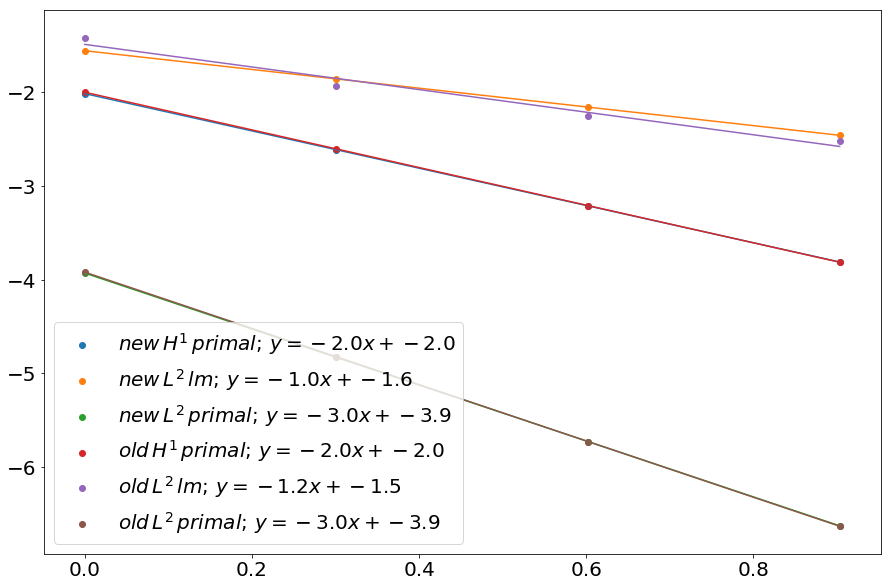

In [64]:
h_array = np.asarray(h_intervals)
for error_label,error_list in plot_dict.items():
    data_array = np.asarray([float(i) for i in error_list])
    z = np.polyfit(np.log10(h_array), np.log10(data_array), 1)
    p = np.poly1d(z)
    plt.plot(np.log10(h_array), p(np.log10(h_array)), '-')
    equation = "y=%.1fx+%.1f" % (z[0],z[1])
    plt.scatter(np.log10(h_array), np.log10(data_array), label=r"$%s %s$" % (error_label, equation))


plt.legend()

In [1]:
from sympy import *

In [2]:
x,y = symbols('x y')

In [3]:
u = x**4 + 2*y**4 +x*y**2
variables = [x, y]

def take_derivs(expressions, variables):
    results = []
    for variable in variables:
        for expr in expressions:
            results.append(diff(expr, variable))
    return results        

first_derivs = take_derivs([u], variables)
second_derivs = take_derivs(first_derivs, variables)
thrid_derivs = take_derivs(second_derivs, variables)

In [13]:
x_tuple = (x, 0, 1)
y_tuple = (y, 0, 1)
integral = integral + integrate(u, x_tuple, y_tuple)

def l2_integ(quant, x_tuple, y_tuple):
    return integrate(quant*quant, x_tuple, y_tuple)

vals = [u] + first_derivs + second_derivs + thrid_derivs
h3_primal_norm = N(sqrt(sum([l2_integ(i, x_tuple, y_tuple) for i in vals])))

In [14]:
h3_primal_norm

33.9576019494712

In [15]:
lm = y**2 + sympify(1) / 2

In [19]:
lm_first_derivs = take_derivs([lm],[y])
lm_vals = [lm] + lm_first_derivs
h1_lm_norm = N(sqrt(sum([integrate(i*i, (y,0,1)) for i in lm_vals])))

In [20]:
h1_lm_norm

1.45487685618635

In [21]:
%matplotlib inline

In [29]:
h = np.logspace(-5,0,1000)
def rhs(h, k, l, Hu, Hlm):
    return h**k * Hu + h**(l+1.5) * Hlm
def first_term(h, k, Hu):
    return h**k * Hu
def second_term(h, l, Hlm):
    return h**(l+1.5) * Hlm
rhs_array = np.asarray([rhs(hi, 2, 0, h3_primal_norm, h1_lm_norm) for hi in h])
first_array = np.asarray([first_term(hi, 2, h3_primal_norm) for hi in h])
second_array = np.asarray([second_term(hi, 0, h1_lm_norm) for hi in h])

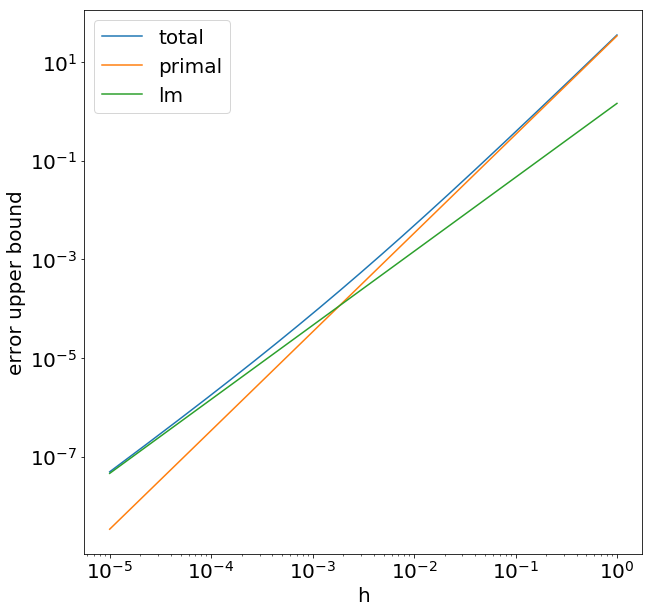

In [43]:
plt.plot(h, rhs_array, label='total')
plt.plot(h, first_array, label='primal')
plt.plot(h, second_array, label='lm')
plt.xscale("log")
plt.yscale("log")
plt.xlabel("h")
plt.ylabel("error upper bound")
plt.legend()